# This is a simple lane detection pipeline for images
In this method I have depolyed simple Computer Vision techniques to employ a pipeline to identify lane lines in an image

Please note: You must be aware of the image size/dimensions while working with your own image, you can adjust the area of attention region polygon points for the same and should get the algorithm work properly in almost any image

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os
os.sys.path
import cv2
# Use cv2_imshow when working in GoogleColab
# from google.colab.patches import cv2_imshow 
%matplotlib inline

In [ ]:
current_dir = os.path.dirname(os.path.abspath(__file__))
image_path = os.path.join(current_dir, 'CV-Projects/test1.jpg')

# Read the image
image = cv2.imread(image_path)

# Check if the image is successfully loaded
if image is None:
    print("Error: Unable to read the image.")
else:
    # Display the image using cv2.imshow()
    cv2.imshow('Image', image)


For Better understanding I have a basic copy of the image assigned in the next line of code

In [17]:
lane_image = np.copy(image)

# Converting to grayscale
In this step the image is converted to a 2 channel color i.e graysacle. This is important to identify sharp change in color of the images for the next step, this is helful to detect Canny Edges

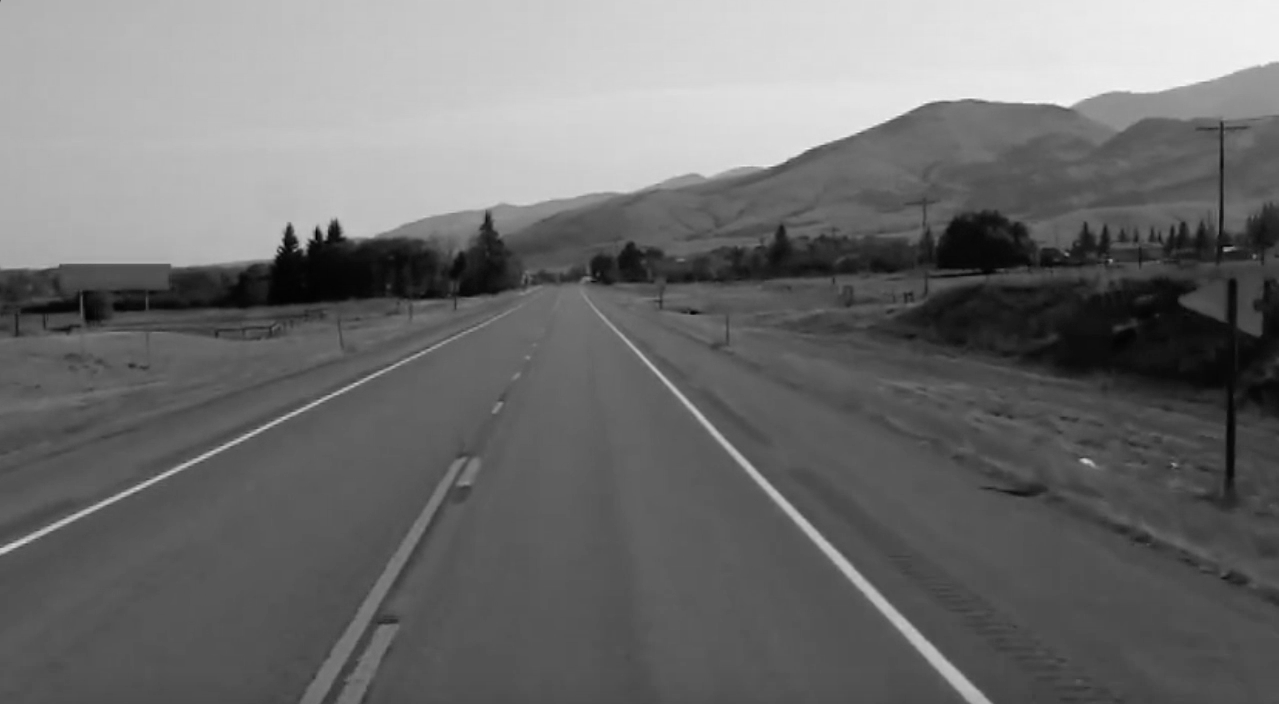

In [13]:
gray = cv2.cvtColor(lane_image, cv2.COLOR_RGB2GRAY)
cv2_imshow(gray)

# **Removing Noise**
Now the Gaussian Blur here will reduce some basic noise from the Image to further clarify it for deep canny edge detection

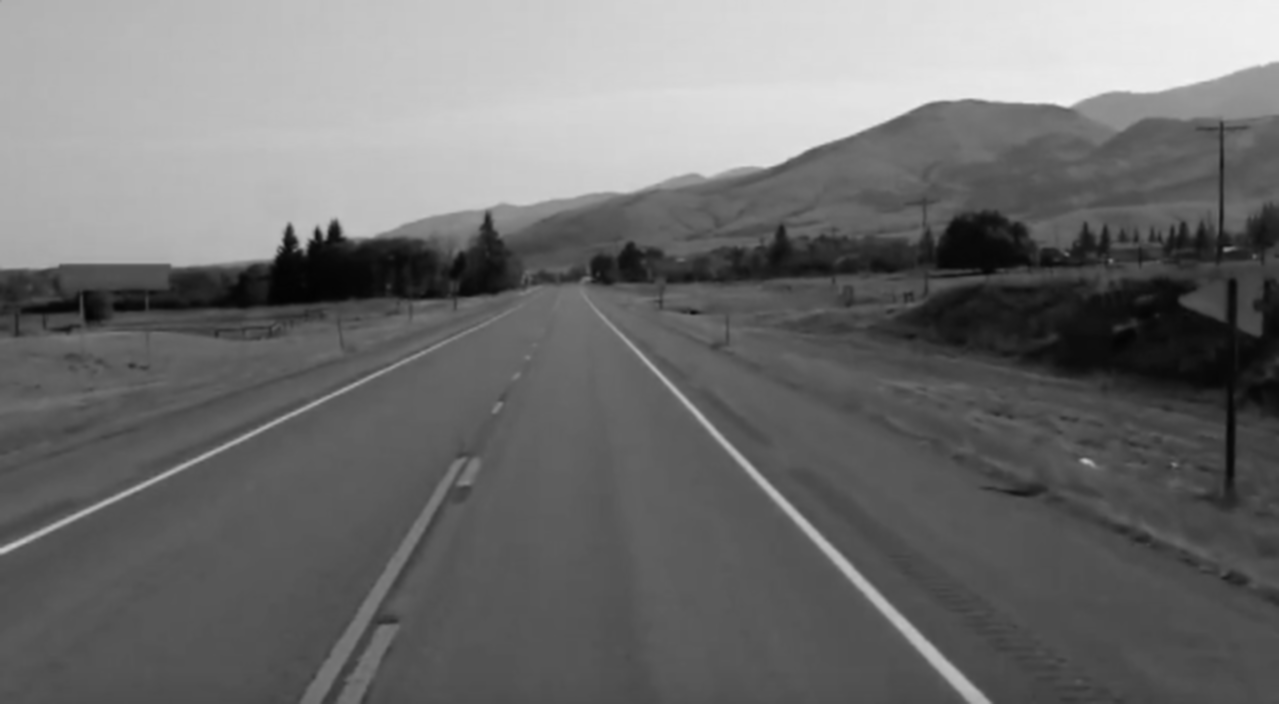

In [14]:
blur = cv2.GaussianBlur(gray, (5,5), 0)
cv2_imshow(blur)

You can adjust the values of the function canny accordingly. Refer OpenCV documents for recent changes if any: https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html

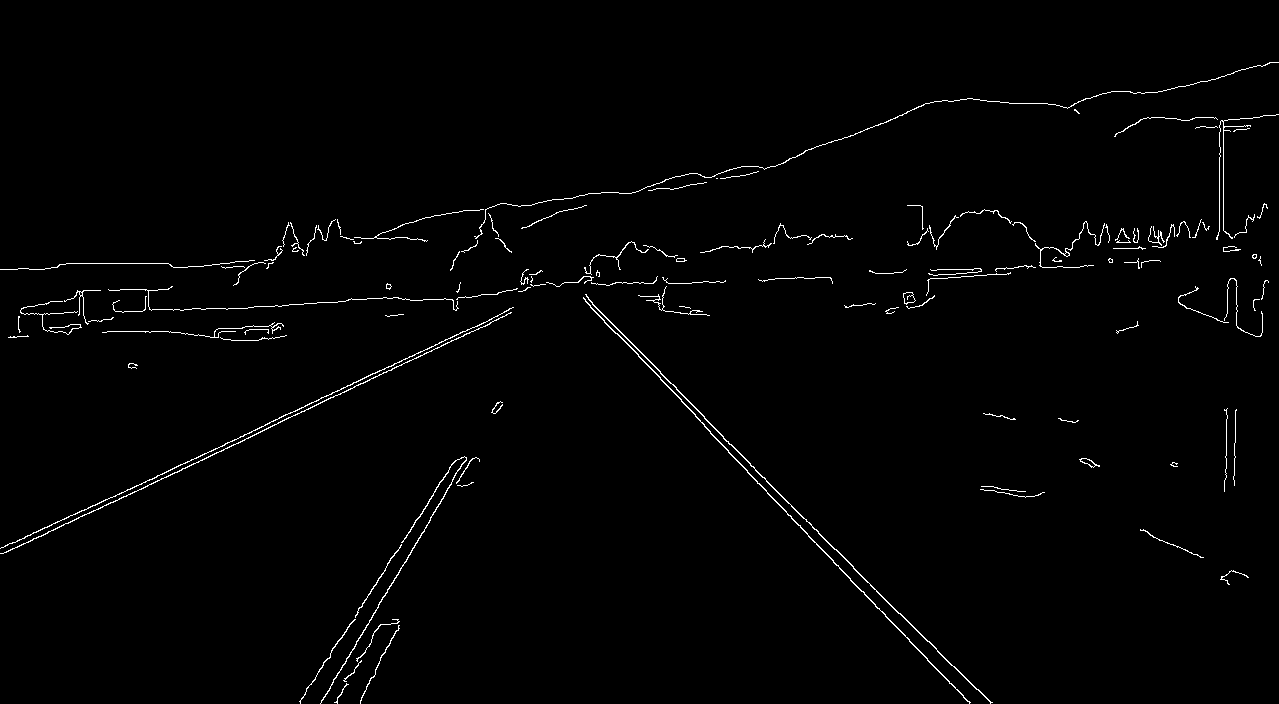

In [15]:
cannyed = cv2.Canny(blur, 50, 100)
cv2_imshow(cannyed)

**Here all the three operatrions are merged into one single fucntion and is plotted on a 2D axis**

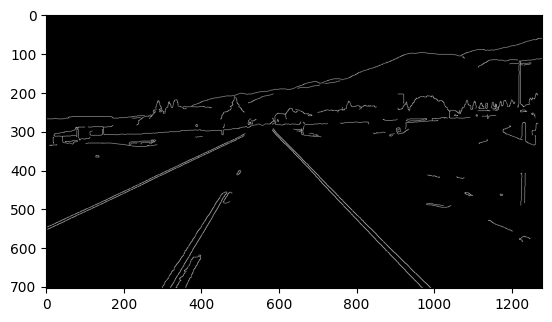

In [16]:
def canny(image):
  gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  blur = cv2.GaussianBlur(gray, (5,5), 0)
  cannyed = cv2.Canny(blur, 50, 100)
  return cannyed

canny = canny(lane_image)
plt.imshow(canny, cmap='gray')
plt.show()

Define the region of interest as a 3 point polygon on the 2D processed image, you can change the Height, Width accordingly

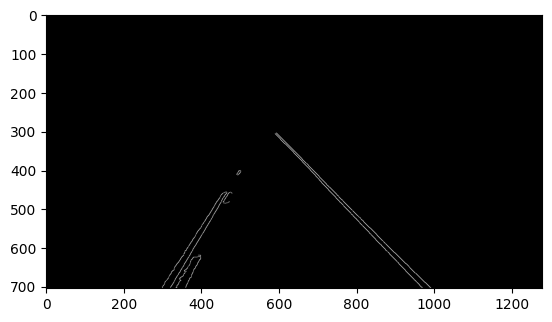

In [17]:
def region_of_interest(image):
  height = image.shape[0]
  height = image.shape[0]
  triangle = np.array([[(0, height), (1000, height), (600, 300)]])
  mask = np.zeros_like(image)
  cv2.fillPoly(mask, triangle, 255)
  masked_image = cv2.bitwise_and(image, mask)
  return masked_image

attention_region = region_of_interest(canny)
plt.imshow(attention_region, cmap='gray')
plt.show()
# cv2_imshow(attention_region)

Apply the Hough Transform for detecting straight lines in the ROI

In [96]:
line = cv2.HoughLinesP(attention_region, 2, np.pi/180, 100, np.array([]), minLineLength=20, maxLineGap=100)

# Displaying the predicted lines

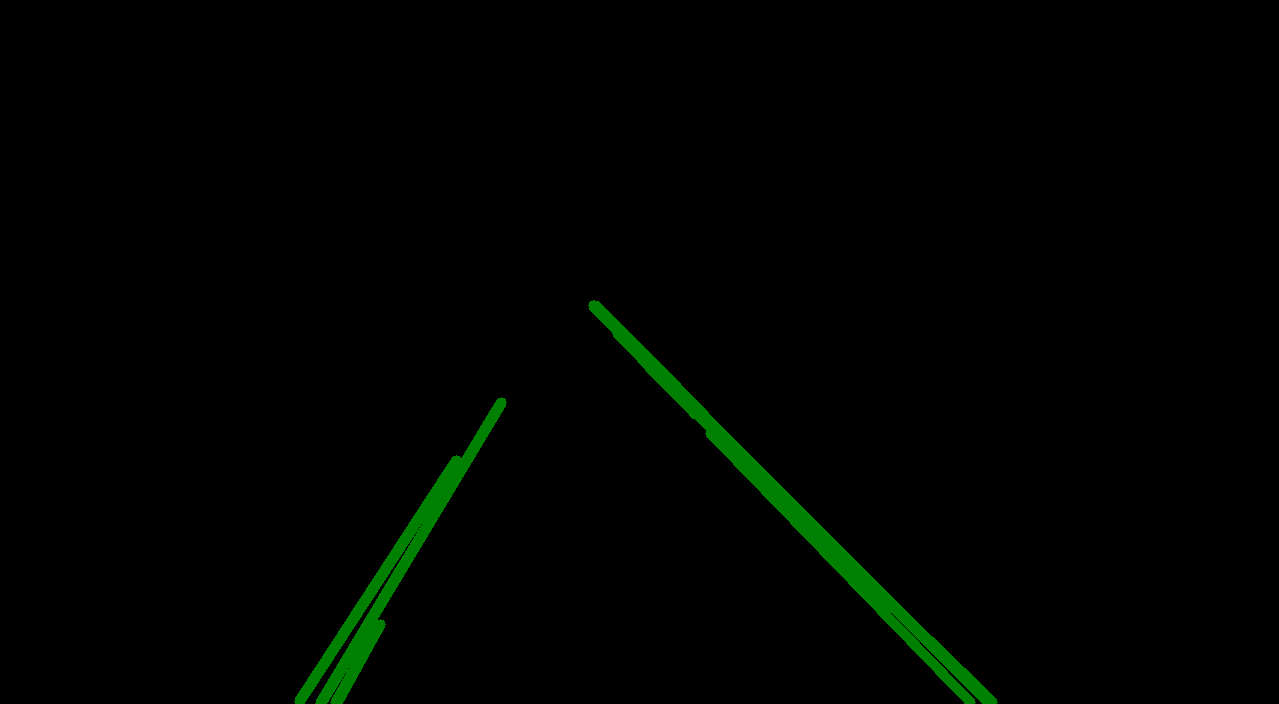

In [121]:
def display_lines(image, lines):
  line_image = np.zeros_like(image)
  if lines is not None:
    for line in lines:
      x1, y1, x2, y2 = line.reshape(4)
      cv2.line(line_image, (x1, y1), (x2, y2), (0,128,0), 10)
  return line_image



line_image = display_lines(lane_image, line)
cv2_imshow(line_image)

Using the Fucntion addWeighted, adding the predicted lines masked image and the main image and displaying it as ONE

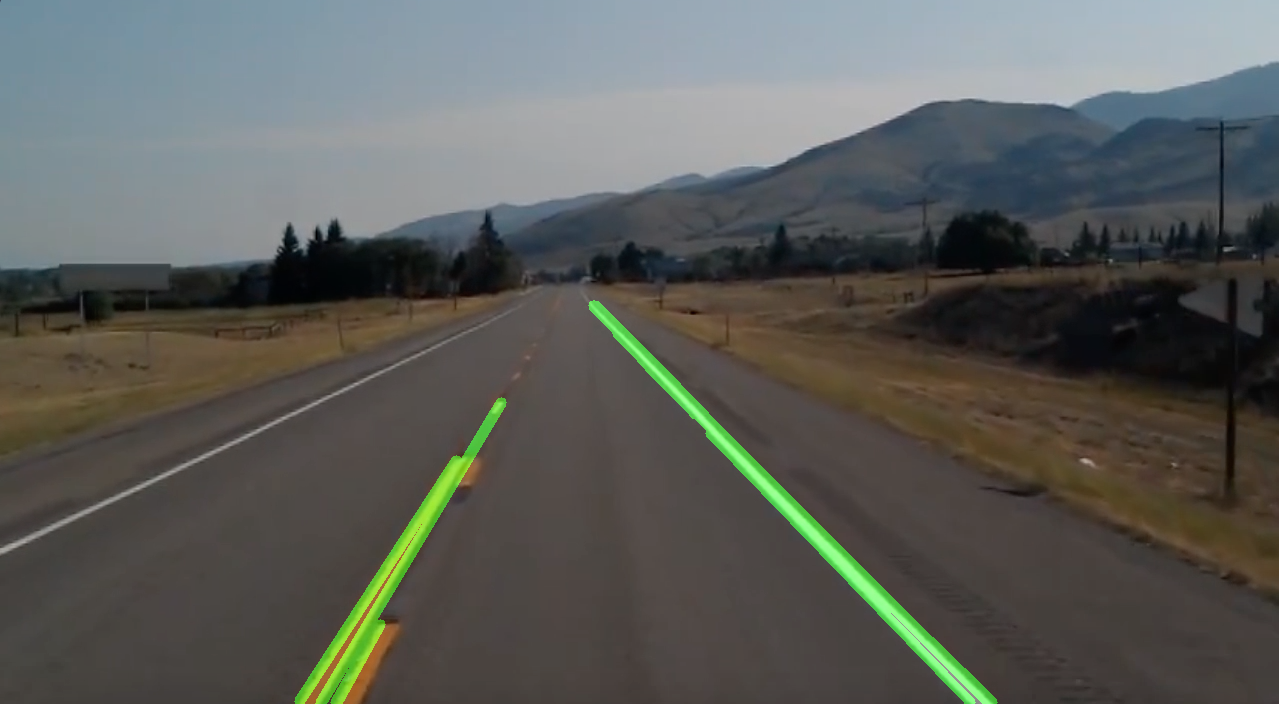

In [127]:
final_image = cv2.addWeighted(lane_image, 0.8, line_image, 1, 1)
cv2_imshow(final_image)

# Cleaning the multiple predicting lines and averaging the lines out

In [128]:
def make_coordinates(image, line_parameters):
    slope, intercept = line_parameters
    y1 = image.shape[0]
    y2 = int(y1 * (3/5))
    x1 = int((y1 - intercept) / slope)
    x2 = int((y2 - intercept) / slope)
    return np.array([x1, y1, x2, y2])


def averaged_slope_intercept(image, lines):
    left_lines = []
    right_lines = []
    mid_x = image.shape[1] // 2

    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        parameters = np.polyfit((x1, x2), (y1, y2), 1)
        slope, intercept = parameters

        if slope < 0 and x1 < mid_x and x2 < mid_x:
            left_lines.append((slope, intercept))
        elif slope > 0 and x1 > mid_x and x2 > mid_x:
            right_lines.append((slope, intercept))

    left_line = make_coordinates(image, np.average(left_lines, axis=0))
    right_line = make_coordinates(image, np.average(right_lines, axis=0))

    return np.array([left_line, right_line])

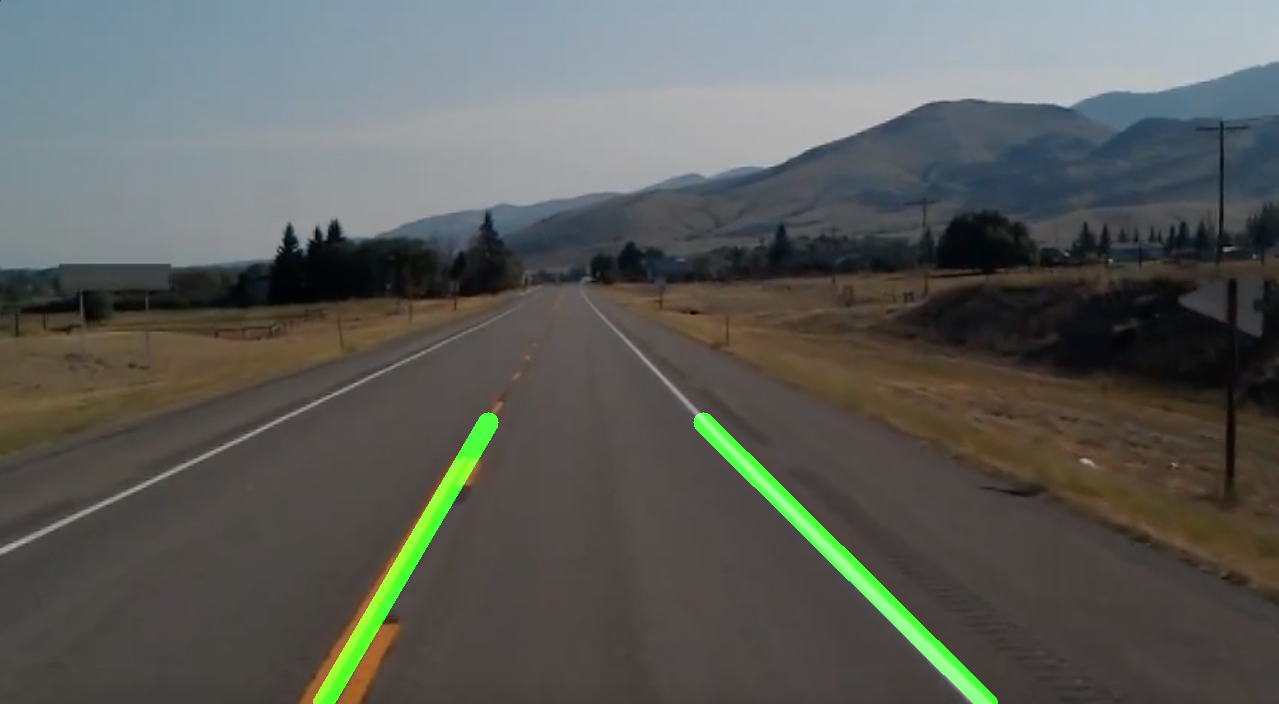

In [131]:
averaged_lines = averaged_slope_intercept(lane_image, line)
line_image_averaged = np.zeros_like(lane_image)
line_image_averaged = display_lines(line_image_averaged, averaged_lines, thickness=20)
final_image_averaged = cv2.addWeighted(lane_image, 0.8, line_image_averaged, 1, 1)
cv2_imshow(final_image_averaged)